In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score, confusion_matrix
from scipy import signal

import torch
import torch.nn as nn
import torch.nn.functional as f

import fastai2 
from fastai2.data.core import DataLoaders
from fastai2.vision.all import *

print("Pytorch:", torch.__version__)
print("Fastai2:", fastai2.__version__)
print("CUDA:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0))

Pytorch: 1.5.0
Fastai2: 0.0.17
CUDA: True
GPU: GeForce GTX 1080 Ti


In [2]:
from bs_finder import *

# Experiments

In [3]:
hyperparams = ["train", "val", "Model",   "BS", "LR", "Epochs", "loss", "labelSmoth", "classWeights", "Seed"]
experiments = [
    ["sdfadf", "val", "Net9", 512, 0.1,   3,   "CE", 0, False, 0],
    ["sdfadf", "val", "Net9", 512, 0.1,   3,   "CE", 0, False, 0],
    ["sdfadf", "val", "Net9", 512, 0.1,   3,   "CE", 0, False, 0],
    ["sdfadf", "val", "Net9", 512, 0.1,   3,   "CE", 0, False, 0],
    ["sdfadf", "val", "Net9", 512, 0.1,   3,   "CE", 0, False, 0],
    ["sdfadf", "val", "Net9", 512, 0.1,   3,   "CE", 0, False, 0],
    ["sdfadf", "val", "Net9", 512, 0.1,   3,   "CE", 0, False, 0],
    ["sdfadf", "val", "Net9", 512, 0.1,   3,   "CE", 0, False, 0],
    ["sdfadf", "val", "Net9", 512, 0.1,   3,   "CE", 0, False, 0],
    ["sdfadf", "val", "Net9", 512, 0.1,   3,   "CE", 0, False, 0],
]


experiments = pd.DataFrame(experiments, columns=hyperparams)
experiments

,train,val,Model,BS,LR,Epochs,loss,labelSmoth,classWeights,Seed
0,sdfadf,val,Net9,512,0.1,3,CE,0,False,0
1,sdfadf,val,Net9,512,0.1,3,CE,0,False,0
2,sdfadf,val,Net9,512,0.1,3,CE,0,False,0
3,sdfadf,val,Net9,512,0.1,3,CE,0,False,0
4,sdfadf,val,Net9,512,0.1,3,CE,0,False,0
5,sdfadf,val,Net9,512,0.1,3,CE,0,False,0
6,sdfadf,val,Net9,512,0.1,3,CE,0,False,0
7,sdfadf,val,Net9,512,0.1,3,CE,0,False,0
8,sdfadf,val,Net9,512,0.1,3,CE,0,False,0
9,sdfadf,val,Net9,512,0.1,3,CE,0,False,0


In [4]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(sees)
    #tf.random.set_seed(seed) # Tensorflow

# Data

In [5]:
train = pd.read_csv('data/train_clean.csv', dtype={'time': np.float32, 'signal': np.float32, 'open_channels':np.int64})
test  = pd.read_csv('data/test_clean.csv',  dtype={'time': np.float32, 'signal': np.float32})
sub   = pd.read_csv('data/sample_submission.csv', dtype={'time': np.float32})

# FEATURES
train["signal"] = np.load('data/0_x_train.npy')
test["signal"]  = np.load('data/0_x_test.npy')
train["group"]  = np.load("data/0_groups_train.npy")
test["group"]   = np.load("data/0_groups_test.npy")

#train["preds"] = np.load("data/1_linear_preds_train.npy")
#test["preds"]  = np.load("data/1_linear_preds_test.npy")

#train["noise"] = np.load("data/2_noise_train.npy")
#test["noise"]  = np.load("data/2_noise_test.npy")

train["x_sin_50hz"] = np.float32(np.load("data/3_x_sin_50hz_train.npy"))
test["x_sin_50hz"]  = np.float32(np.load("data/3_x_sin_50hz_test.npy"))

train["x_sin_freqs"] = np.load("data/3_x_without_freqs_linPred_train.npy")
test["x_sin_freqs"]  = np.load("data/3_x_without_freqs_linPred_test.npy")



#train_signal = np.float32(np.load("data/train_x_without50hz.npy"))
#test["signal"] = np.float32(np.load("data/test_x_without50hz.npy"))
test["open_channels"] = 0 # CHAPUZA para ahorrar codigo

In [6]:
train.head()

,time,signal,open_channels,group,x_sin_50hz,x_sin_freqs
0,0.0001,-2.7600,0,0,-2.708945,-2.704058
1,0.0002,-2.8557,0,0,-2.804274,-2.799828
2,0.0003,-2.4074,0,0,-2.355654,-2.351915
3,0.0004,-3.1404,0,0,-3.088385,-3.085588
4,0.0005,-3.1525,0,0,-3.100266,-3.098599


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   time           float32
 1   signal         float32
 2   open_channels  int64  
 3   group          int64  
 4   x_sin_50hz     float32
 5   x_sin_freqs    float32
dtypes: float32(4), int64(2)
memory usage: 152.6 MB


In [8]:
train_gr0 = pd.concat([train[      0: 500000], train[ 500000:1000000]])
train_gr1 = pd.concat([train[1000000:1500000], train[3000000:3500000]])
train_gr2 = pd.concat([train[1500000:2000000], train[3500000:4000000]])
train_gr3 = pd.concat([train[2500000:3000000], train[4000000:4500000]])
train_gr4 = pd.concat([train[2000000:2500000], train[4500000:5000000]])

In [9]:
train_for_test = pd.concat([train_gr0[:-1000000],
                            train_gr1[:-100000],
                            train_gr2[:-200000],
                            train_gr3[:-200000],
                            train_gr4[:-200000]])

valid_like_test = pd.concat([train_gr0[-1000000:],
                             train_gr1[-100000:],
                             train_gr2[-200000:],
                             train_gr3[-200000:],
                             train_gr4[-200000:]])

# DataLoader
- Poner onhot grupo en entrada
- Agumatation
  - Leer a la inversa

In [10]:
class DS(torch.utils.data.Dataset):
    def __init__(self, df, win_size=9):
        self.win_size   = win_size
        _x         = torch.tensor(np.pad(df["signal"].values,      pad_width=win_size//2, mode='edge'))
        _x_50hz    = torch.tensor(np.pad(df["x_sin_50hz"].values, pad_width=win_size//2, mode='edge'))
        _x_clean   = torch.tensor(np.pad(df["x_sin_freqs"].values, pad_width=win_size//2, mode='edge'))
        #_50hz     = torch.tensor(np.pad(df["50hz"].values,       pad_width=win_size//2, mode='edge'))
        #_noise    = torch.tensor(np.pad(df["noise"].values,      pad_width=win_size//2, mode='edge'))
        self._group = torch.tensor(np.pad(df["group"].values, pad_width=win_size//2, mode='edge'))
        _g_oh       = F.one_hot(self._group, num_classes=5).float()

        xfeats     = torch.stack((_x_50hz, _x_clean), dim=1)#.float() #_x_50hz.unsqueeze(0)
        self.feats = torch.cat([xfeats, _g_oh], dim=1)
        self._y  = df["open_channels"].values
        
        
        #self.scalogram = signal.cwt(data=df["signal"].values, wavelet=signal.ricker, widths=np.arange(1, 31))
        
    def __len__(self):
        return len(self._y)
    
    def __getitem__(self, i):
        window    = self.feats[i:i+self.win_size]
        #group     = torch.tensor(self._group[i],  dtype=torch.int64)
        #group_oh  = F.one_hot(group, num_classes=5).float()
        #scalogram = torch.tensor(self.scalogram[:,i]).float() # array of 30
        
        #x = torch.cat([group_oh, window]) # scalogram
        y = torch.tensor(self._y[i], dtype=torch.long)
        return (window.T, y)

In [11]:
#g5toy_train = DS(train4[:100000], win_size=9)
#g5toy_valid = DS(train9[:100000], win_size=9)
#
#g5big_train = DS(train4, win_size=9)
#g5big_valid = DS(train9, win_size=9)
#
#m = 10000
#toy_train = DS(pd.concat([train0[:m], train2[:m], train7[:m], train5[:m], train4[:m]]), win_size=9)
#toy_valid = DS(pd.concat([train1[:m], train6[:m], train3[:m], train8[:m], train9[:m]]), win_size=9)
#
#half_train = DS(pd.concat([train0, train2, train7, train5, train9]), win_size=9)
#half_valid = DS(pd.concat([train1, train6, train3, train8, train4]), win_size=9)
#
#all_train = DS(train, win_size=9)
#
#test_ds  = DS(test, win_size=9)
#
#BS = 256 # 256, 512
#dls_g5toy = DataLoaders.from_dsets(g5toy_train, g5toy_valid, test_ds, bs=BS, device=torch.device("cuda"))
#dls_g5big = DataLoaders.from_dsets(g5big_train, g5big_valid, test_ds, bs=BS, device=torch.device("cuda"))
#dls_toy   = DataLoaders.from_dsets(toy_train,   toy_valid,   test_ds, bs=BS, device=torch.device("cuda"))
#dls_half  = DataLoaders.from_dsets(half_train,  half_valid,  test_ds, bs=4000, device=torch.device("cuda"))
#dls_all   = DataLoaders.from_dsets(all_train,   toy_valid,   test_ds, bs=3000, device=torch.device("cuda"))

In [12]:
dl  = DataLoaders.from_dsets(DS(train_for_test), DS(valid_like_test),DS(test), bs=3000, device="cuda")
dl_all = DataLoaders.from_dsets(DS(train), DS(train[:100000]),DS(test), bs=4000, device="cuda")

# Model: Net 9

In [13]:
# TODO: ReLU , BatchNorm, Dropout

class Net9(nn.Module):
    def __init__(self, n_feats=1):
        super(Net9, self).__init__()
        
        ################### FEATURE EXTRACTOR: 137 feats
        self.li = nn.Linear(in_features=n_feats,  out_features=16)
        self.bn0 = nn.BatchNorm1d(n_feats)
        self.c1  = nn.Conv1d(in_channels=n_feats,  out_channels=64, kernel_size=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.c2  = nn.Conv1d(in_channels=64, out_channels=24, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(24)
        self.c3  = nn.Conv1d(in_channels=24, out_channels=16, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(16)
        self.c4  = nn.Conv1d(in_channels=16, out_channels=8,  kernel_size=3);
        self.bn4 = nn.BatchNorm1d(8)
        self.relu = nn.ReLU(inplace=True)
                
        ################### CLASSIFIER: Dense 128->256->64->11
        self.classifier = nn.Sequential(
            nn.Linear(in_features=128,  out_features=256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=False),
            nn.Dropout(p=0.1, inplace=False),
            nn.Linear(in_features=256,  out_features=64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=False),
            nn.Dropout(p=0.1, inplace=False),
            nn.Linear(in_features=64, out_features=11))

        
    def forward(self, x): # (BS, c=8, L=9)
        
        #group_oh = x[0] # (BS, 5)
        #window   = x[1] # (BS, c=8, L=9)
        
        ################### FEATURE EXTRACTOR
        
        #window = self.bn0(window)
        c1_res = self.bn1(self.c1(x))
        c2_res = self.bn2(self.c2(self.relu(c1_res)))
        c3_res = self.bn3(self.c3(self.relu(c2_res)))
        c4_res = self.c4(self.relu(c3_res))
        
        li_final = self.li(x[:,:,4])  # 16 feats
        c1_final = c1_res[:,:,3:-3].squeeze(2) # 32 feats
        c2_final = c2_res[:,:,2:-2].squeeze(2) # 32 feats
        c3_final = c3_res[:,:,1:-1].squeeze(2) # 32 feats       
        c4_final = c4_res.squeeze(2)           # 32 feats     
        
        # 101 feats:  16 (li) + 64 (cnn1) + 24 (cnn2) + 16 (cnn3) + 8 (cnn4)
        #print(group_oh.shape, li_final.shape, c1_final.shape, c2_final.shape, c3_final.shape, c4_final.shape)
        feats = torch.cat([li_final, c1_final, c2_final, c3_final, c4_final], dim=1)
        #print(feats.shape)
        
        ################### CLASSIFIER
        return self.classifier(feats)
            
net9 = Net9(n_feats=7)

In [14]:
dl.dataset[0][0].shape

torch.Size([7, 9])

In [15]:
net9.eval()
net9(dl.dataset[0][0].unsqueeze(0))
net9.train();

# Weigted class

In [13]:
dls         = dls_half, # dls_toy, dls_half, dls_g5toy, dls_g5big
train_preds = dls[0].array_y

AttributeError: 'DS' object has no attribute 'array_y'

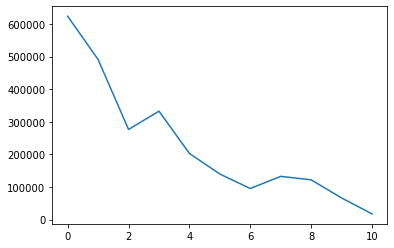

In [13]:
plt.plot(np.bincount(train_preds));

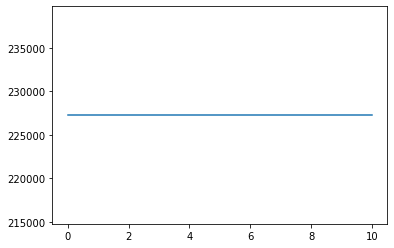

In [14]:
class_weights = np.bincount(train_preds).sum() / (11 * np.bincount(train_preds))
plt.plot(np.bincount(train_preds) * class_weights);

In [15]:
class_weights=torch.FloatTensor(class_weights).cuda()

RuntimeError: cuda runtime error (999) : unknown error at ../aten/src/THC/THCGeneral.cpp:47

# Neighbour Label Smoothing

In [13]:
class SmartLabelSmoothingCE(Module):
    def __init__(self, label_smoothing:float=0.0): 
        self.label_smoothing = Tensor([
            [0,1,0,0,0,0,0,0,0,0,0],
            [1,0,1,0,0,0,0,0,0,0,0],
            [0,1,0,1,0,0,0,0,0,0,0],
            [0,0,1,0,1,0,0,0,0,0,0],
            [0,0,0,1,0,1,0,0,0,0,0],
            [0,0,0,0,1,0,1,0,0,0,0],
            [0,0,0,0,0,1,0,1,0,0,0],
            [0,0,0,0,0,0,1,0,1,0,0],
            [0,0,0,0,0,0,0,1,0,1,0],
            [0,0,0,0,0,0,0,0,1,0,1],
            [0,0,0,0,0,0,0,0,0,1,0],
        ])
        self.label_smoothing  *= (label_smoothing / self.label_smoothing.sum(dim=1,keepdims=True))
        self.label_smoothing += (1-label_smoothing) * torch.eye(11)
        
    def forward(self, logits, true):
        n_classes = logits.size()[-1]
        y_pred = logits.view(-1,n_classes)    
        y_true = self.label_smoothing[true.flatten()].view(-1,n_classes).to(logits.device)
        return (- y_true * F.log_softmax(y_pred, dim=1)).sum(dim=1).mean()

# Train

In [16]:
# TODO: Weighted by class
# TODO: Better loss for F1 macro??? Focal??
# TODO: Adam, Radam,...
learn = Learner(dls       = dl_all, # dl, #dls_half, dls_g5big, dls_g5toy, dls_g5, dls
                model     = net9,
                loss_func = nn.CrossEntropyLoss(weight=None), # SmartLabelSmoothingCE(0.25), F.cross_entropy, CrossEntropyLossFlat(),
                metrics   = [F1Score(average='macro'), accuracy],
                cbs       = [ShowGraphCallback()])
learn.model.cuda()
#learn.summary()

Net9(
  (li): Linear(in_features=7, out_features=16, bias=True)
  (bn0): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c1): Conv1d(7, 64, kernel_size=(3,), stride=(1,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c2): Conv1d(64, 24, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c3): Conv1d(24, 16, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c4): Conv1d(16, 8, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear

SuggestedLRs(lr_min=0.05248074531555176, lr_steep=0.02290867641568184)

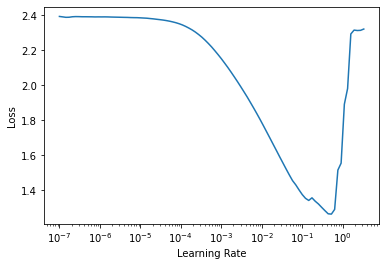

In [17]:
learn.lr_find()

In [18]:
10e-2

0.1

In [20]:
learn.bs_find(lr=0.1, simulate_multi_gpus=False)

IndexError: list index out of range

In [17]:
100000/512 *3

585.9375

epoch,train_loss,valid_loss,f1_score,accuracy,time
0,0.102220,0.002156,0.661493,0.999270,01:47
1,0.090093,0.001074,0.996136,0.999640,01:47
2,0.082652,0.000911,0.996780,0.999700,01:46


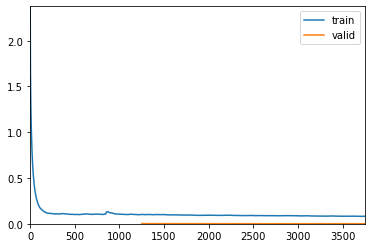

In [18]:
## DL ALL:, 50 y ALL, OH at first
learn.fit_one_cycle(n_epoch=3, lr_max=0.1)

epoch,train_loss,valid_loss,f1_score,accuracy,time
0,0.121371,0.062620,0.934323,0.980170,01:41
1,0.110848,0.052857,0.929228,0.979752,01:38
2,0.100189,0.045227,0.941999,0.982703,01:39


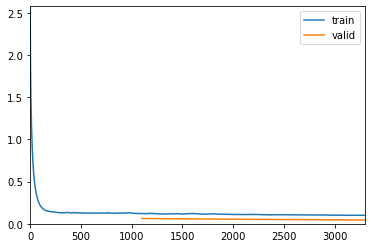

In [17]:
## raw, 50 y ALL, OH at first
learn.fit_one_cycle(n_epoch=3, lr_max=0.1)

epoch,train_loss,valid_loss,f1_score,accuracy,time
0,0.125878,0.128915,0.812406,0.956888,02:47
1,0.113472,0.062715,0.926397,0.977862,02:46
2,0.103461,0.049999,0.941199,0.981245,02:46


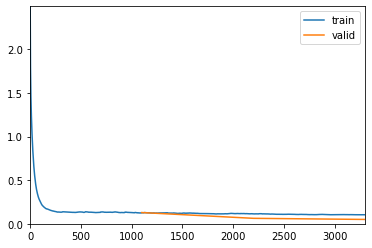

In [17]:
## raw, 50 y ALL
learn.fit_one_cycle(n_epoch=3, lr_max=0.1)

epoch,train_loss,valid_loss,f1_score,accuracy,time
0,0.127842,0.061732,0.920492,0.977573,02:50
1,0.112840,0.059303,0.937488,0.979226,02:52
2,0.102468,0.049265,0.941223,0.981408,02:50


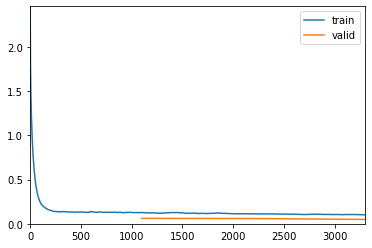

In [17]:
## 50 y ALL 2o run
learn.fit_one_cycle(n_epoch=3, lr_max=0.1)

epoch,train_loss,valid_loss,f1_score,accuracy,time
0,0.133417,0.060348,0.924727,0.978039,02:49
1,0.112148,0.058138,0.938688,0.978337,02:48
2,0.102726,0.049427,0.941168,0.981178,02:49


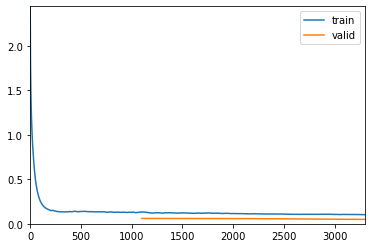

In [17]:
## 50 y ALL
learn.fit_one_cycle(n_epoch=3, lr_max=0.1)

epoch,train_loss,valid_loss,f1_score,accuracy,time
0,0.127415,0.121461,0.880639,0.955031,02:54
1,0.116323,0.055281,0.937538,0.980143,02:56
2,0.104992,0.049281,0.941450,0.981654,02:55


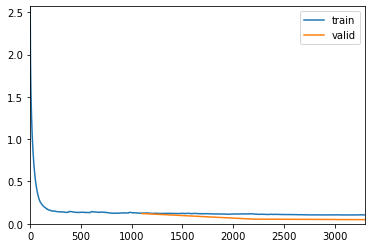

In [22]:
## solo 50
learn.fit_one_cycle(n_epoch=3, lr_max=0.1)

In [16]:
#learn.fit_one_cycle(n_epoch=6, lr_max=0.05)

In [30]:
#learn.save("net9_all_6eps_lr5e-2")

epoch,train_loss,valid_loss,f1_score,accuracy,time
0,0.108623,0.098499,0.928146,0.963012,02:52
1,0.095575,0.077533,0.937880,0.970230,02:49
2,0.089041,0.073470,0.942592,0.971831,02:48


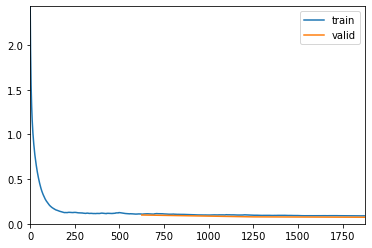

In [17]:
learn.fit_one_cycle(n_epoch=3, lr_max=0.1)

In [6]:
learn.recorder.plot_loss()

NameError: name 'learn' is not defined

# Validación

In [24]:
#interp = ClassificationInterpretation.from_learner(learn)
#interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [25]:
preds,targs = learn.get_preds()

preds = torch.max(preds, 1)[1].numpy()
targs = targs.numpy()
len(preds)

1700000

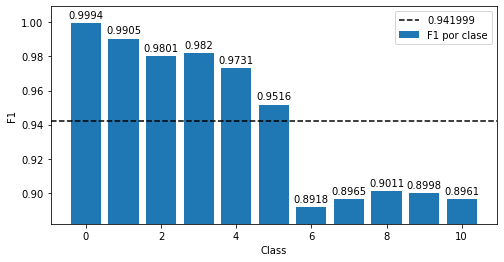

In [26]:
f1 = f1_score(preds, targs, average=None)

plt.figure(figsize=(8, 4))
plt.ylim([min(f1)-0.01, max(f1)+0.01])
plot = plt.bar(list(range(0,11)), f1)
plt.axhline(f1.mean(), color='k', linestyle='--')

for value in plot:
    height = value.get_height()
    plt.text(value.get_x() + value.get_width()/2., 1.002*height,round(height,4), ha='center', va='bottom')

plt.xlabel("Class")
plt.ylabel("F1")
plt.legend([str(round(f1.mean(),6)),"F1 por clase"])
plt.show()

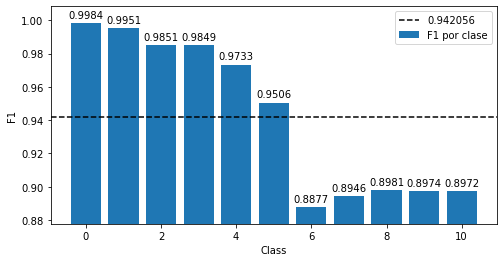

In [18]:
f1 = f1_score(preds, targs, average=None)

plt.figure(figsize=(8, 4))
plt.ylim([min(f1)-0.01, max(f1)+0.01])
plot = plt.bar(list(range(0,11)), f1)
plt.axhline(f1.mean(), color='k', linestyle='--')

for value in plot:
    height = value.get_height()
    plt.text(value.get_x() + value.get_width()/2., 1.002*height,round(height,4), ha='center', va='bottom')

plt.xlabel("Class")
plt.ylabel("F1")
plt.legend([str(round(f1.mean(),6)),"F1 por clase"])
plt.show()

In [27]:
preds_df = pd.DataFrame({'preds': preds, 'targs': targs})

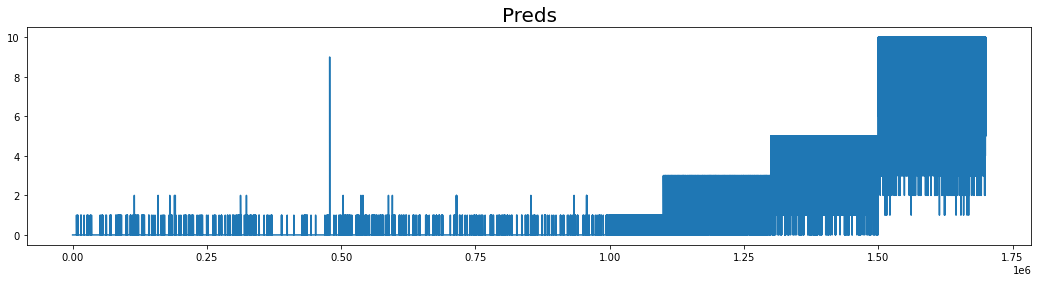

In [29]:
plt.figure(figsize=(18, 4)); plt.plot(preds); plt.title("Preds",fontsize=20);

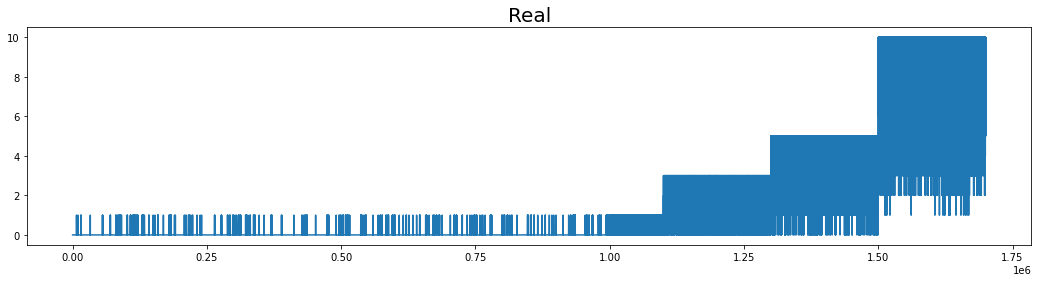

In [30]:
plt.figure(figsize=(18, 4)); plt.plot(targs); plt.title("Real",fontsize=20);

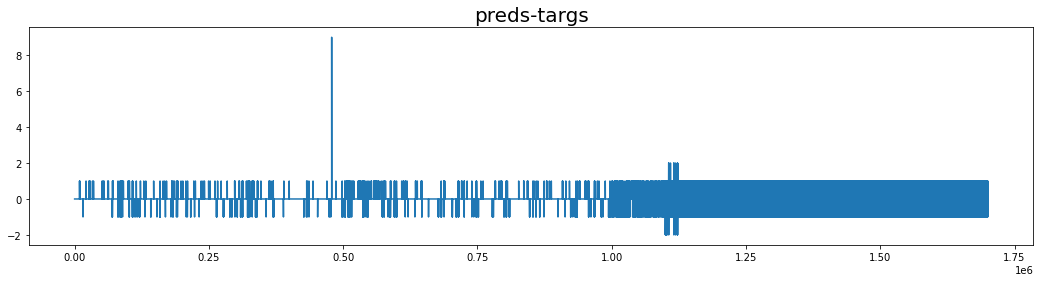

In [31]:
plt.figure(figsize=(18, 4)); plt.plot(preds-targs); plt.title("preds-targs",fontsize=20);

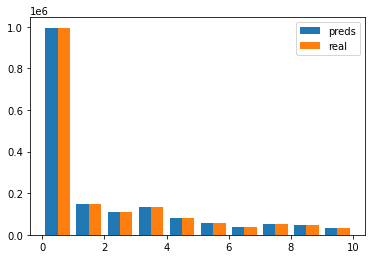

In [32]:
plt.hist([preds, targs], label=['preds', 'real'])
plt.legend(loc='upper right')
plt.show()

In [33]:
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score, confusion_matrix

print("Accuracy:    ", accuracy_score(preds, targs))
print("Balanced acc:", balanced_accuracy_score(preds, targs))
print("F1 score:    ", f1_score(preds, targs, average='macro'))
print("Confus mat:\n", confusion_matrix(preds, targs))

Accuracy:     0.9827029411764706
Balanced acc: 0.9433512351036787
F1 score:     0.9419993344023823
Confus mat:
 [[994801    765      7      0      0      0      0      0      0      0
       0]
 [   478 147772    650     23      0      0      0      0      0      0
       0]
 [     7    912 109049   1503      0      0      0      0      0      0
       0]
 [     0     18   1360 131365   1074      0      0      0      0      0
       0]
 [     0      0      0    837  78523   1224      0      0      0      0
       0]
 [     0      0      0      0   1200  53125   1447      0      0      0
       0]
 [     0      0      0      0      0   1535  33833   2602      0      0
       0]
 [     0      0      0      0      0      0   2622  47821   3228      0
       0]
 [     0      0      0      0      0      0      0   2591  44326   2049
       0]
 [     2      0      0      0      0      0      0      0   1863  23907
     824]
 [     0      0      0      0      0      0      0      0      0    

In [28]:
ran = len(preds) // 5

print("Gr 1 F1", f1_score(preds[ran*0:ran*1], targs[ran*0:ran*1], average='macro'))
print("Gr 2 F1", f1_score(preds[ran*1:ran*2], targs[ran*1:ran*2], average='macro'))
print("Gr 3 F1", f1_score(preds[ran*2:ran*3], targs[ran*2:ran*3], average='macro'))
print("Gr 4 F1", f1_score(preds[ran*3:ran*4], targs[ran*3:ran*4], average='macro'))
print("Gr 5 F1", f1_score(preds[ran*4:ran*5], targs[ran*4:ran*5], average='macro'))

Gr 1 F1 0.6639813194446448
Gr 2 F1 0.9966595700013653
Gr 3 F1 0.9864116010265567
Gr 4 F1 0.9733168456644817
Gr 5 F1 0.7267555866969556


# Test

In [19]:
preds_t,targs_t = learn.get_preds(ds_idx=2)

preds_t = torch.max(preds_t, 1)[1].numpy()
#targs_t.numpy()
preds_t

array([0, 0, 0, ..., 0, 0, 0])

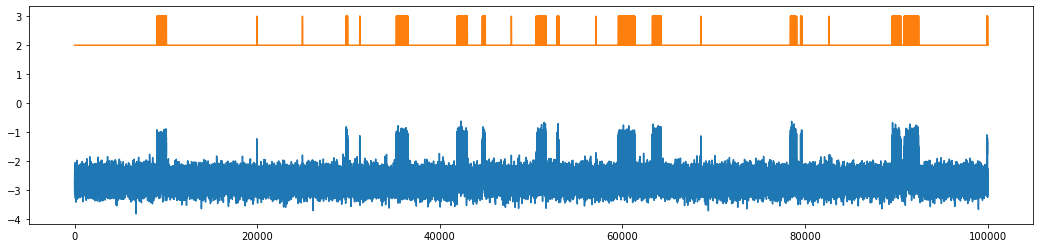

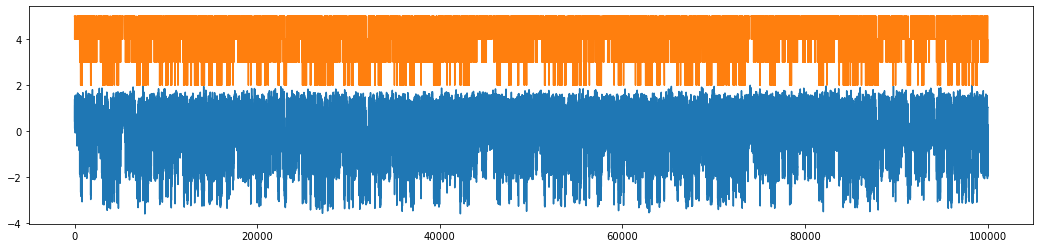

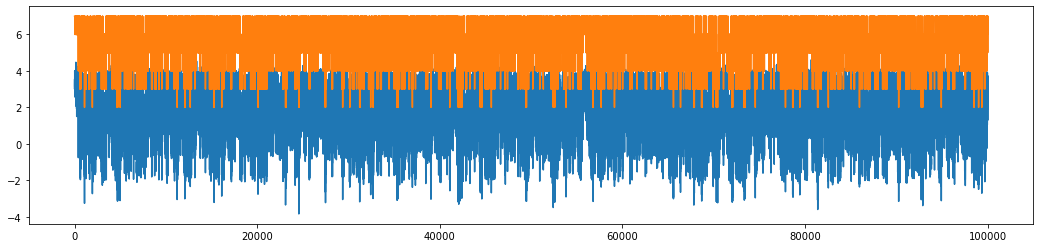

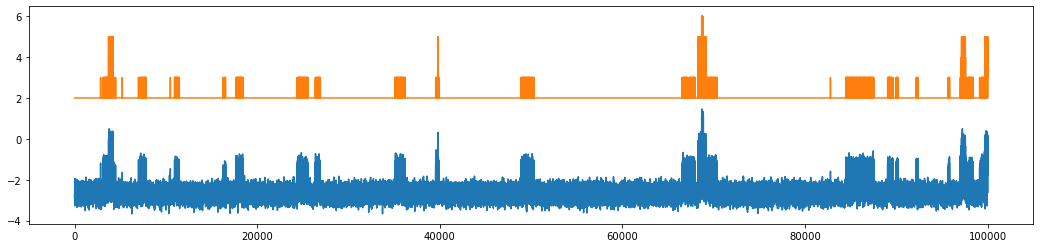

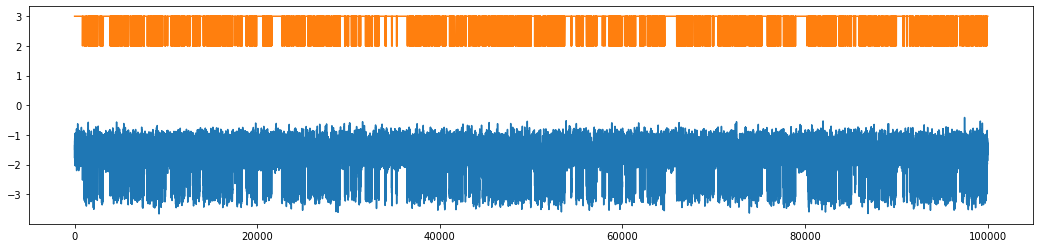

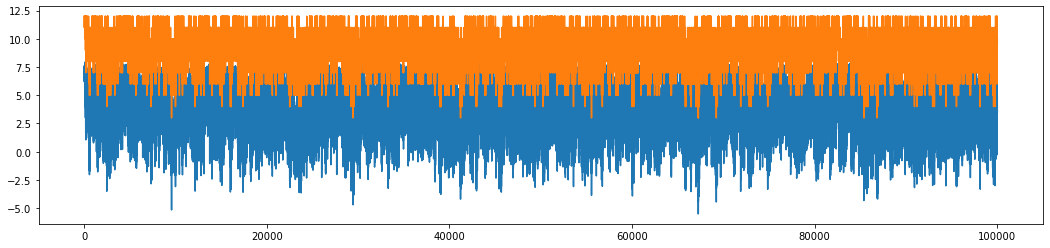

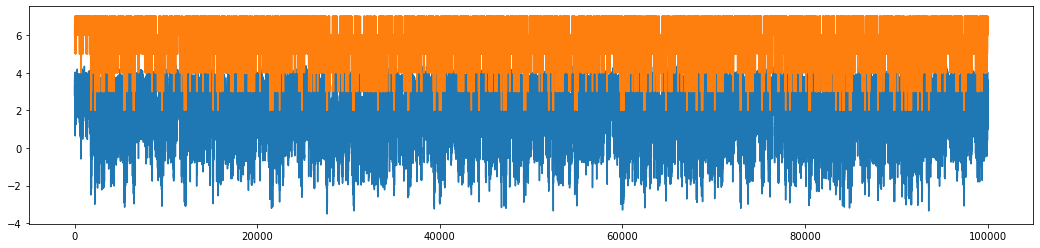

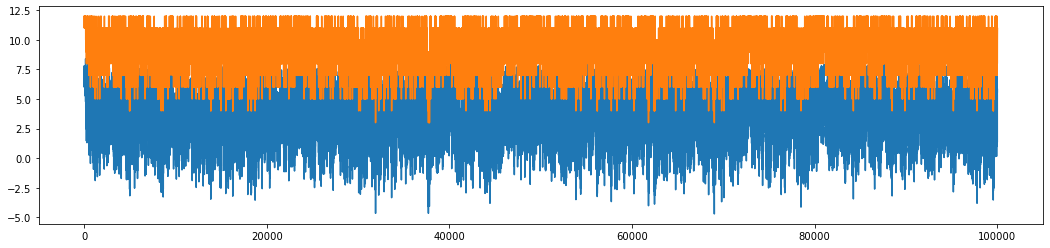

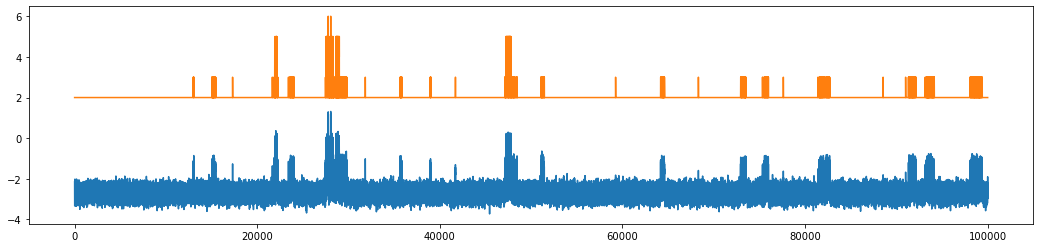

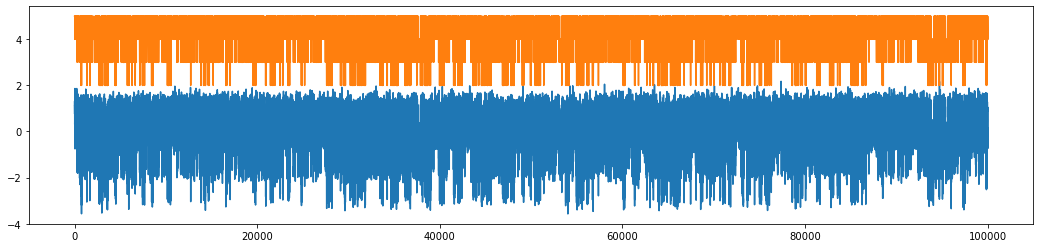

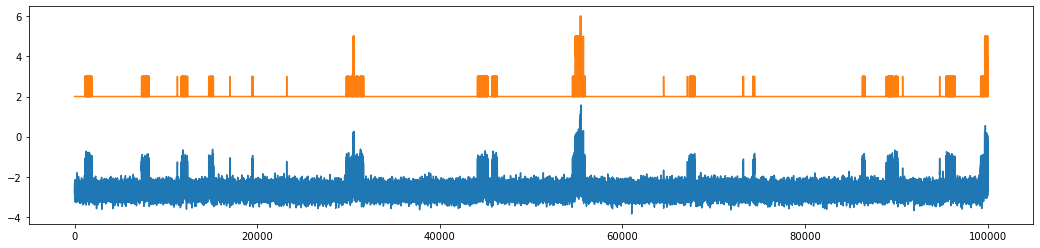

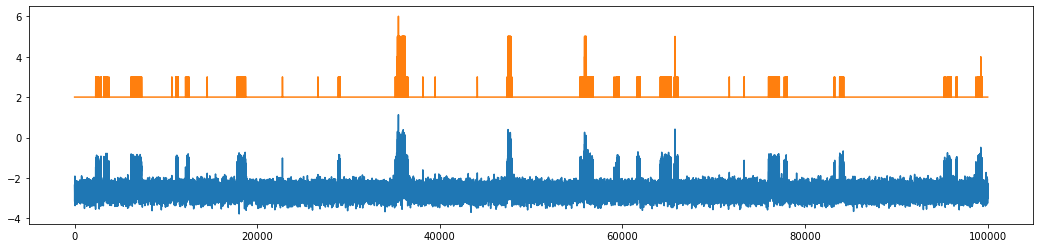

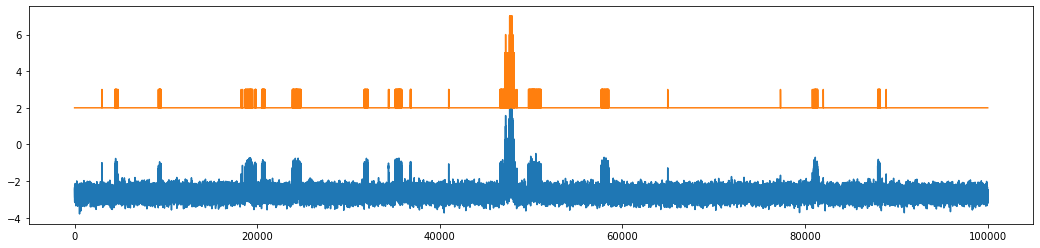

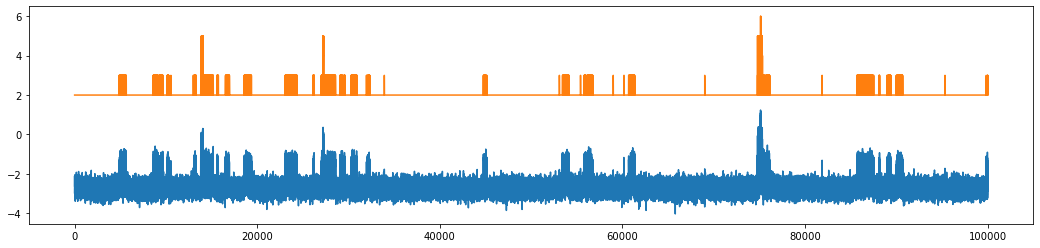

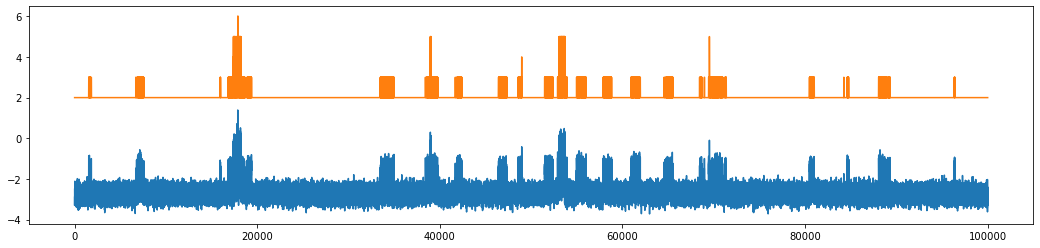

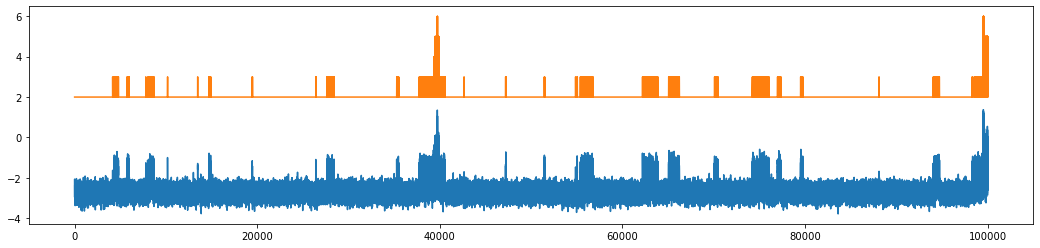

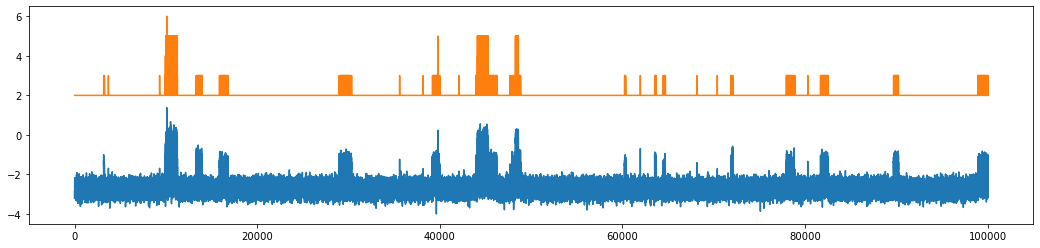

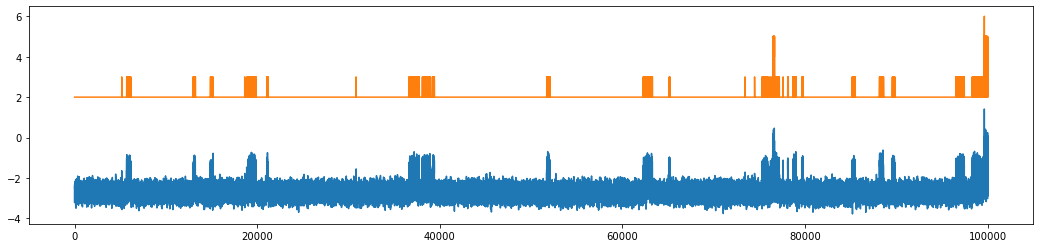

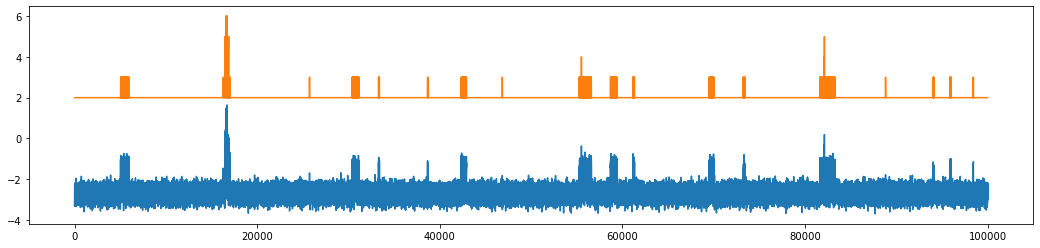

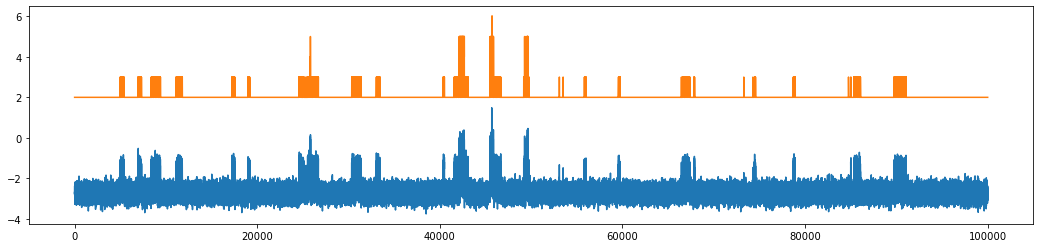

In [23]:
for x,p in zip(np.split(test.signal.values,20), np.split(preds_t,20)):
    plt.figure(figsize=(18, 4))
    plt.plot(x);
    plt.plot(p+2);

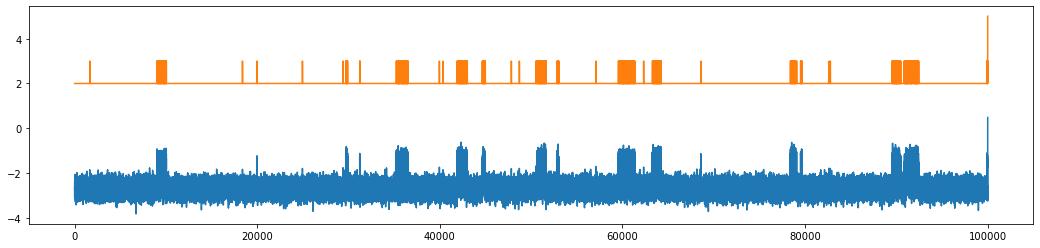

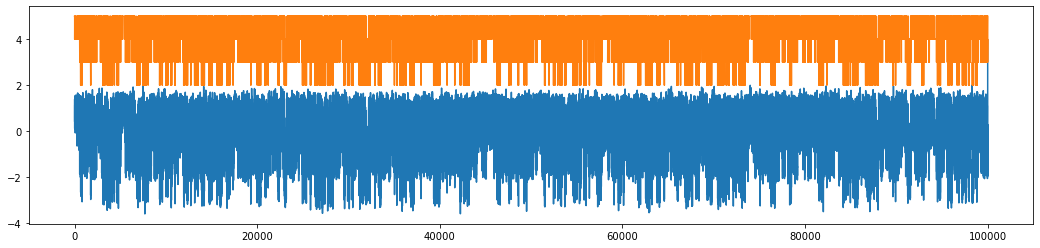

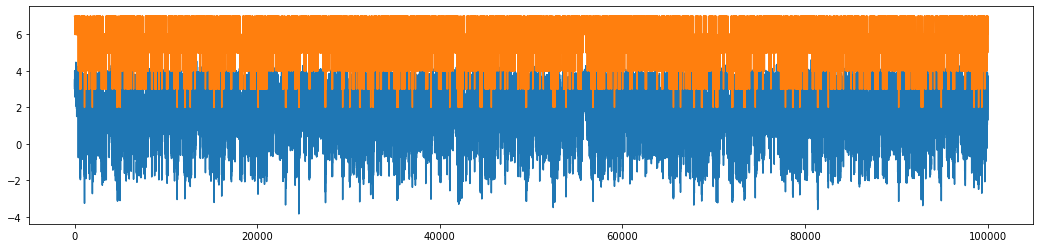

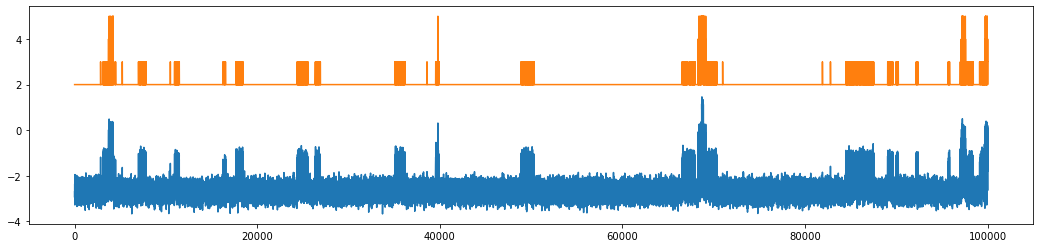

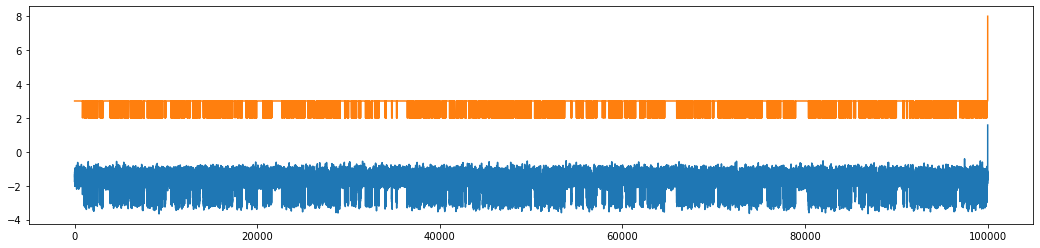

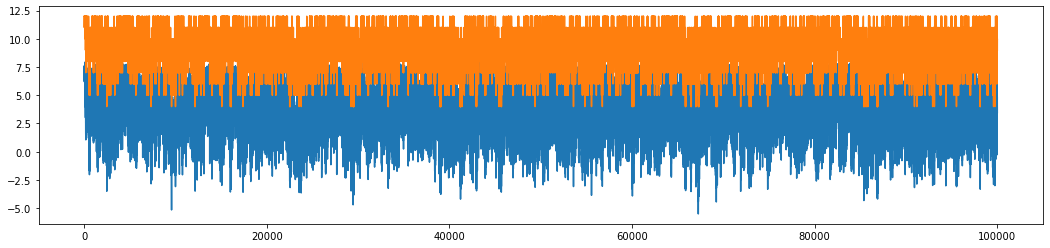

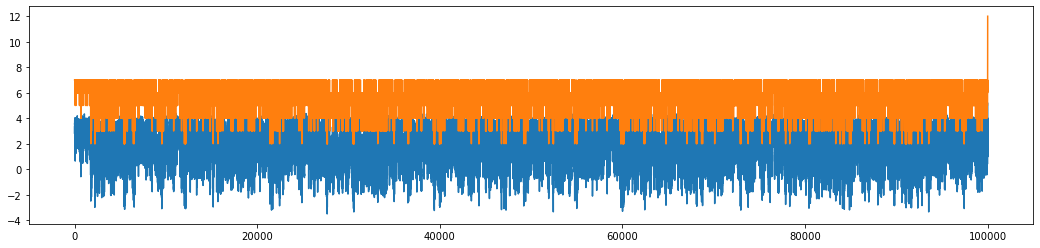

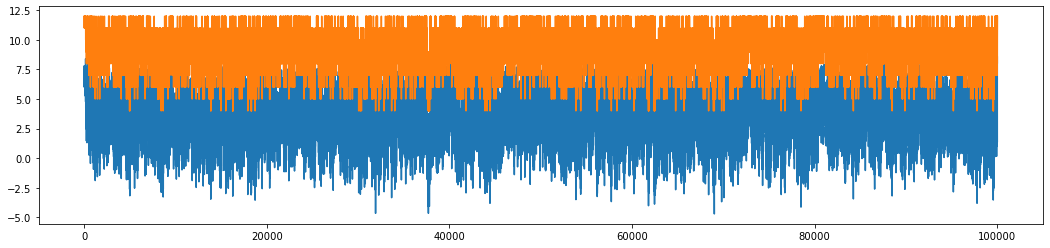

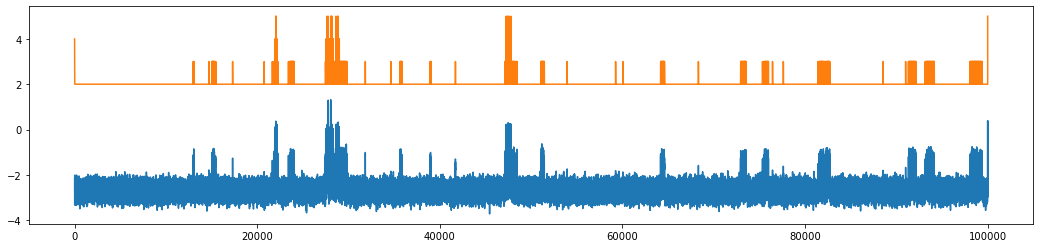

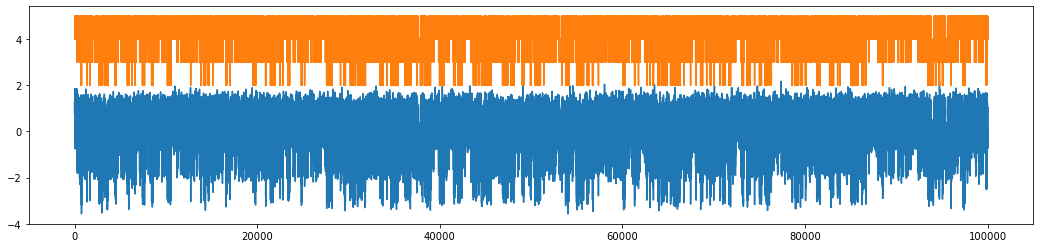

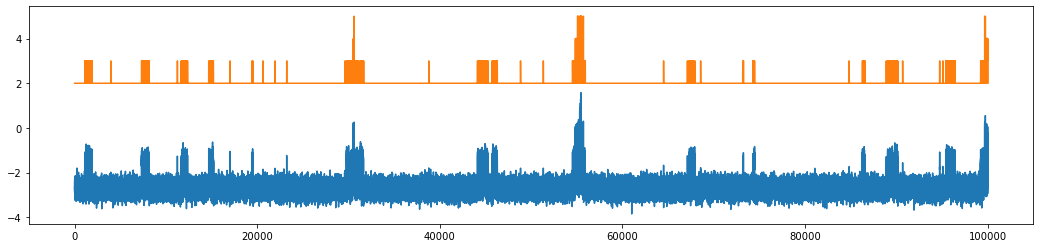

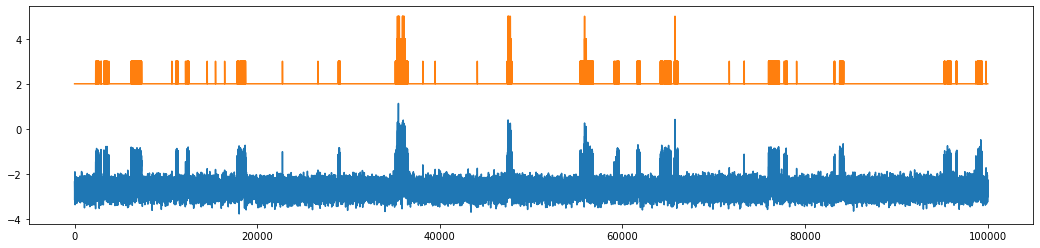

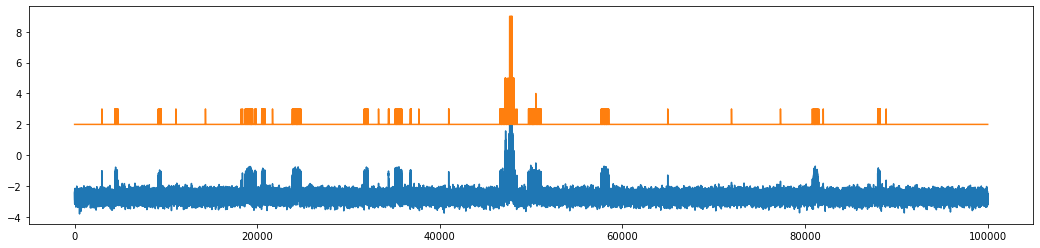

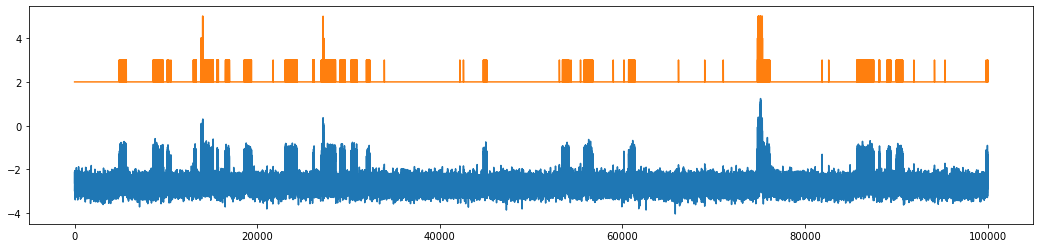

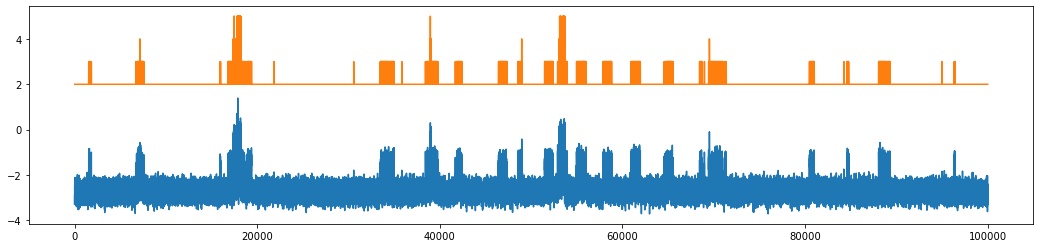

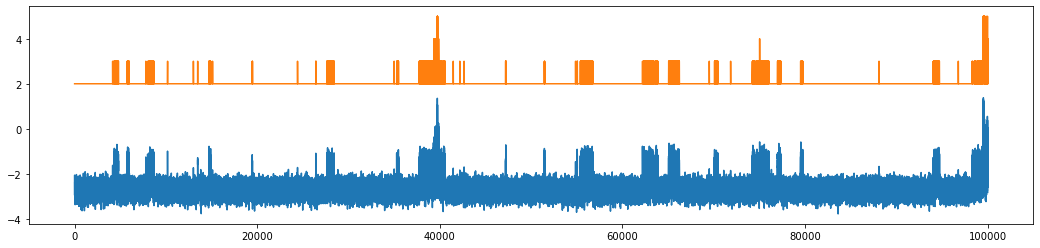

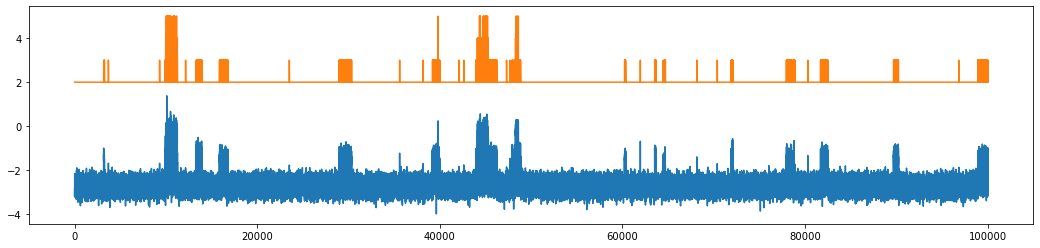

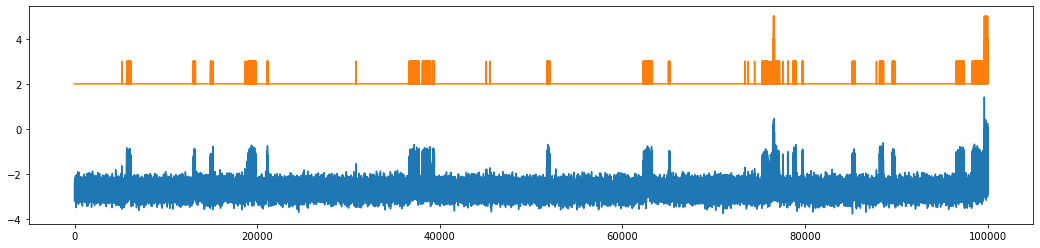

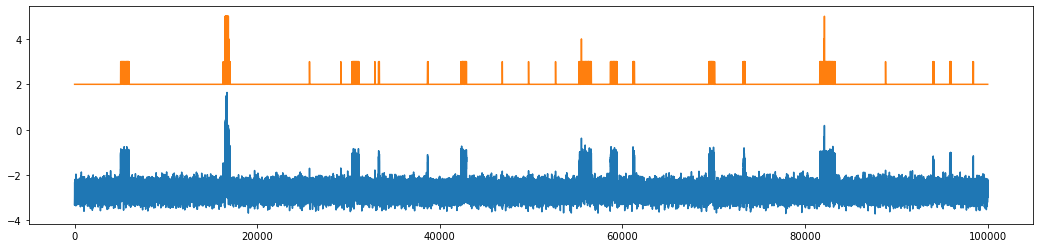

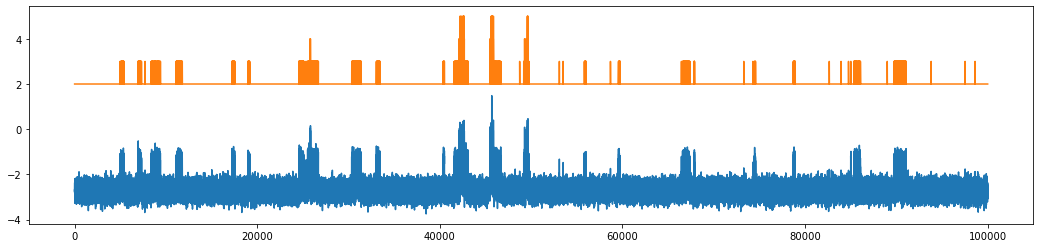

In [21]:
for x,p in zip(np.split(test.signal.values,20), np.split(preds_t,20)):
    plt.figure(figsize=(18, 4))
    plt.plot(x);
    plt.plot(p+2);

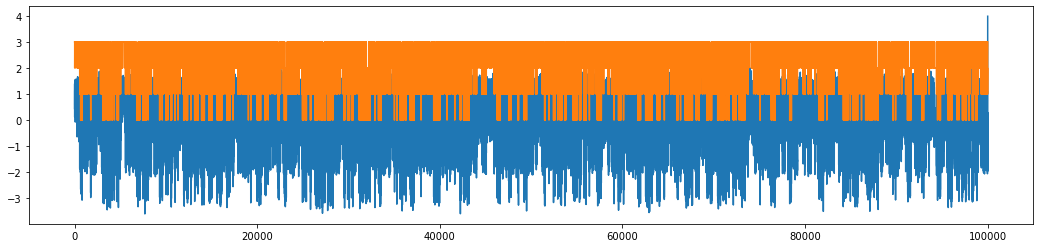

In [39]:
explore_test_preds(100000,200000)

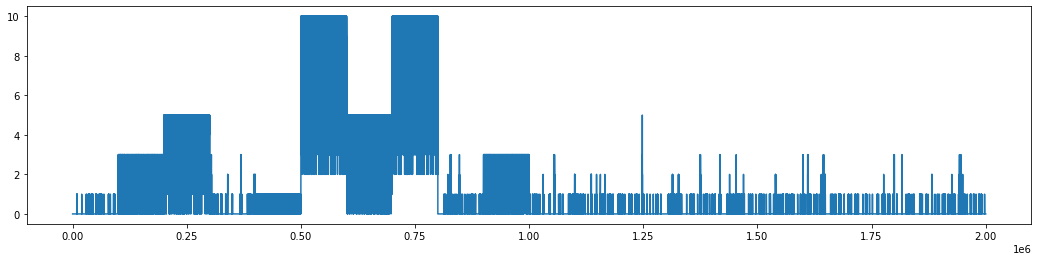

In [36]:
plt.figure(figsize=(18, 4))
plt.plot(preds_t);

In [21]:
sub["open_channels"] = preds_t
sub

,time,open_channels
0,500.000092,0
1,500.000214,0
2,500.000305,0
3,500.000397,0
4,500.000488,0
...,...,...
1999995,699.999573,0
1999996,699.999695,0
1999997,699.999817,0
1999998,699.999878,0


In [21]:
sub["open_channels"].mean()

1.3794905

In [22]:
sub.to_csv("subs/net9_x&50hz&ALL_dsALL.csv", index=False, float_format="%.4f")

In [23]:
! head -n 12 "subs/net9_x&50hz&ALL_newdl.csv"

time,open_channels
500.0001,0
500.0002,0
500.0003,0
500.0004,0
500.0005,0
500.0006,0
500.0007,0
500.0008,0
500.0009,0
500.0010,0
500.0011,0


In [37]:
! head -n 12 data/sample_submission.csv

time,open_channels
500.0001,0
500.0002,0
500.0003,0
500.0004,0
500.0005,0
500.0006,0
500.0007,0
500.0008,0
500.0009,0
500.0010,0
500.0011,0


# Log


- Params
  - train: [0,2,7,5,9]
  - valid: [1,6,3,8,4]
  - BatchSize: 4000
  - Epochs: 3
  - Time E: 02:26
  - LR: 0.01
  - Loss: CE
  - Class Weigths: No
- Run 1
  - Gr 1 F1 0.9960806900290803
  - Gr 2 F1 0.9963459588420289
  - Gr 3 F1 0.9848021867504615
  - Gr 4 F1 0.9710975308321843
  - Gr 5 F1 0.7341472785857227
  - Mio: **0.9390239**
  - Kaggle: **0.939**
- Run 2
  - Gr 1 F1 0.9957449314364408
  - Gr 2 F1 0.9962454423859943
  - Gr 3 F1 0.9843876249290537
  - Gr 4 F1 0.9716066765153251
  - Gr 5 F1 0.7842656523598383
  - Mio: **0.938917**